In [5]:
%pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\guilh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [29]:
device

'cuda'

In [7]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [8]:
train_DS = MNIST('./content', train=True, download=True, transform=img_transform)
val_DS = MNIST('./content', train=False, download=True, transform=img_transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 3.52MB/s]


Extracting ./content\MNIST\raw\train-images-idx3-ubyte.gz to ./content\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 215kB/s]


Extracting ./content\MNIST\raw\train-labels-idx1-ubyte.gz to ./content\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 1.68MB/s]


Extracting ./content\MNIST\raw\t10k-images-idx3-ubyte.gz to ./content\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.02MB/s]


Extracting ./content\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./content\MNIST\raw



In [ ]:
import torch.nn as nn
import torch

class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28*28,128), nn.ReLU(True),
            nn.Linear(128,64), nn.ReLU(True),
            nn.Linear(64,latent_dim))
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,64),nn.ReLU(True),
            nn.Linear(64,128),nn.ReLU(True),
            nn.Linear(128,28*28),nn.Tanh()) # Tanh para normalizar a saída entre -1 e 1

    def forward(self,x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x

In [30]:
def train_batch(input, model, optimizer, criterion):
    model.train()
    input = input.to(device)
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    input = input.to(device)
    output = model(input)
    loss = criterion(output, input)
    return loss

In [11]:
%pip install fastprogress

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\guilh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Users\guilh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1, 28, 28])) that is different to the input size (torch.Size([1, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


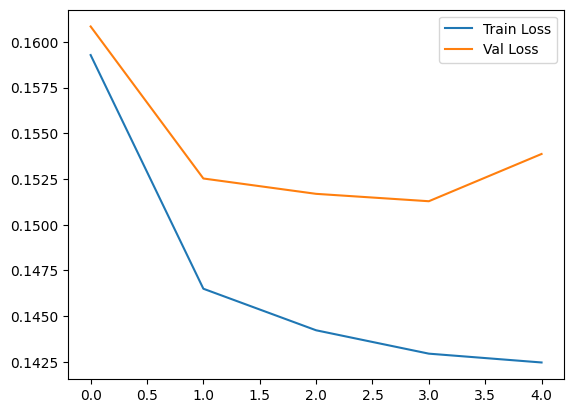

In [ ]:
from fastprogress import master_bar, progress_bar

model = AutoEncoder(3).to(device) # O espaço latente tem dimensão 3
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=0.001,weight_decay=1e-5)
num_epochs = 5
train_losses, val_losses = [], []

mb = master_bar(range(num_epochs))
for epoch in mb:
    trn_loss_epoch = 0
    for ix, (data, _) in enumerate(progress_bar(train_DS, parent=mb)):
        loss = train_batch(data, model, optimizer, criterion)
        trn_loss_epoch += loss.item()
        mb.child.comment = f"Train Loss: {loss.item():.4f}"
    train_losses.append(trn_loss_epoch / len(train_DS))

    val_loss_epoch = 0
    for ix, (data, _) in enumerate(progress_bar(val_DS, parent=mb)):
        loss = validate_batch(data, model, criterion)
        val_loss_epoch += loss.item()
        mb.child.comment = f"Val Loss: {loss.item():.4f}"
    val_losses.append(val_loss_epoch / len(val_DS))

    mb.write(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}")

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

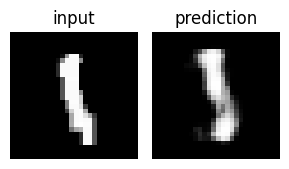

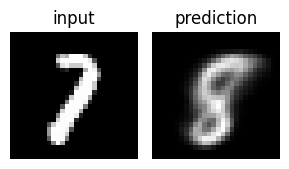

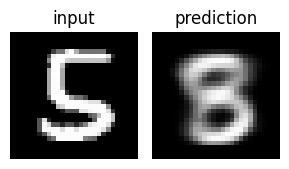

In [ ]:
model.eval()

for _ in range(3):
    ix = np.random.randint(len(val_DS))
    im, _ = val_DS[ix]
    
    im = im.to(device)
    
    with torch.no_grad():
        _im = model(im[None])[0].cpu()
    
    fig, ax = plt.subplots(1, 2, figsize=(3, 3))
    show(im[0].cpu(), ax=ax[0], title='input')  # mostra a imagem original
    show(_im[0], ax=ax[1], title='prediction')  # mostra a reconstrução
    plt.tight_layout()
    plt.show()